# 第7章　建立自定义物体检测器

## 基于HOG描述符检测人

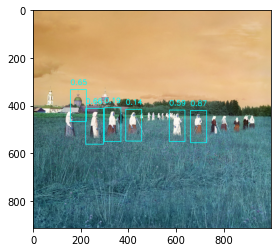

In [7]:
import cv2
from matplotlib import pyplot as plt
def is_inside(i, o):
    ix, iy, iw, ih = i
    ox, oy, ow, oh = o
    return ix > ox and ix + iw < ox + ow  and iy > oy and iy + ih < oy + oh

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
img = cv2.imread("images/haying.jpg")
found_rects, found_weights = hog.detectMultiScale(img, winStride=(4, 4), scale=1.02, finalThreshold=1.9)
found_rects_filtered = []
found_weights_filtered = []
for ri , r in enumerate(found_rects):
    for qi, q in enumerate(found_rects):
        if ri != qi and is_inside(r, q):
            break
        else:
            found_rects_filtered.append(r)
            found_weights_filtered.append(found_weights[ri])
for ri, r in enumerate(found_rects_filtered):
    x,  y, w, h = r
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)
    text = f"{found_weights_filtered[ri][0]:.2f}"
    cv2.putText(img, text, (x, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

plt.imshow(img)
plt.show()

## 检测汽车

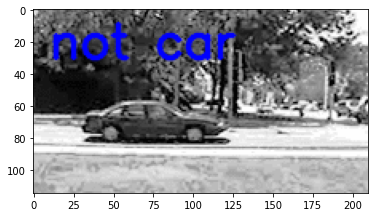

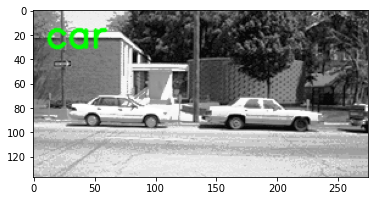

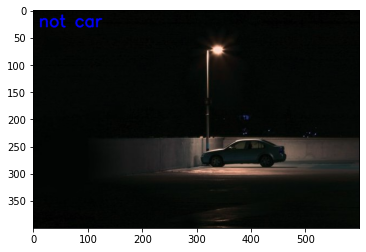

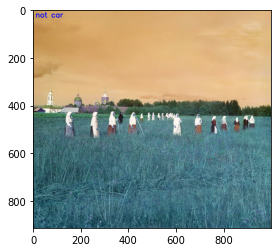

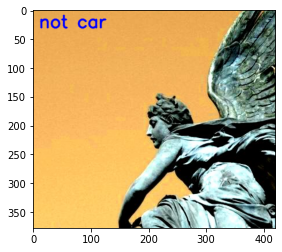

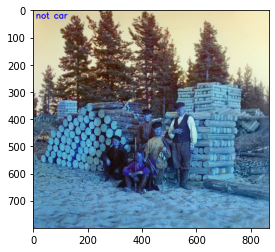

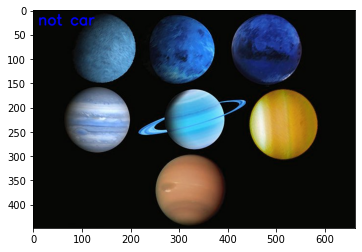

In [26]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

BOW_NUM_TRAINING_SAMPLES_PER_CLASS = 10
SVM_NUM_TRAINING_SAMPLES_PER_CLASS = 400
sift = cv2.SIFT_create()
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = {}
flann = cv2.FlannBasedMatcher(index_params, search_params)
bow_kmeans_trainer = cv2.BOWKMeansTrainer(40)
bow_extractor = cv2.BOWImgDescriptorExtractor(sift, flann)

def get_pos_and_neg_paths(i):
    pos_path = f"data/CarData/TrainImages/pos-{i+1}.pgm"
    neg_path = f"data/CarData/TrainImages/neg-{i+1}.pgm"
    return pos_path, neg_path

def add_sample(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    if descriptors is not None:
        bow_kmeans_trainer.add(descriptors)

for i in range(BOW_NUM_TRAINING_SAMPLES_PER_CLASS):
    pos_path, neg_path = get_pos_and_neg_paths(i)
    add_sample(pos_path)
    add_sample(neg_path)
voc = bow_kmeans_trainer.cluster()
bow_extractor.setVocabulary(voc)

def extract_bow_descriptors(img):
    features = sift.detect(img)
    return bow_extractor.compute(img, features)

training_data = []
training_labels = []
for i in range(SVM_NUM_TRAINING_SAMPLES_PER_CLASS):
    pos_path, neg_path = get_pos_and_neg_paths(i)
    pos_img  = cv2.imread(pos_path, cv2.IMREAD_GRAYSCALE)
    pos_descriptors = extract_bow_descriptors(pos_img)
    if pos_descriptors is not None:
        training_data.extend(pos_descriptors)
        training_labels.append(1)
    neg_img  = cv2.imread(neg_path, cv2.IMREAD_GRAYSCALE)
    neg_descriptors = extract_bow_descriptors(neg_img)
    if neg_descriptors is not None:
        training_data.extend(neg_descriptors)
        training_labels.append(-1)
svm = cv2.ml.SVM_create()
svm.train(np.array(training_data), cv2.ml.ROW_SAMPLE, np.array(training_labels))

for test_img_path in ["data/CarData/TestImages/test-0.pgm", "data/CarData/TestImages/test-1.pgm", "images/car.jpg", \
"images/haying.jpg", "images/statue_small.jpg", "images/woodcutters.jpg", "images/planet_glow.jpg"]:
    img = cv2.imread(test_img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    descriptors = extract_bow_descriptors(gray_img)
    prediction = svm.predict(descriptors)
    if prediction[1][0][0] == 1.0:
        text = 'car'
        color = (0, 255, 0)
    else:
        text = 'not car'
        color = (0, 0, 255)
    cv2.putText(img, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    plt.imshow(img)
    plt.show()

## 检测场景中的汽车

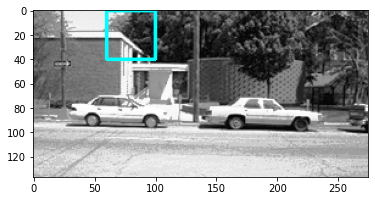

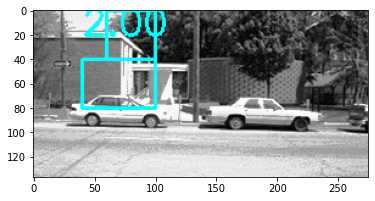

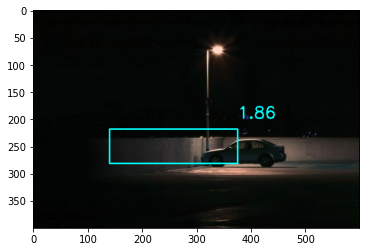

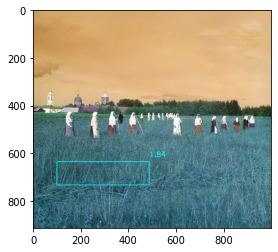

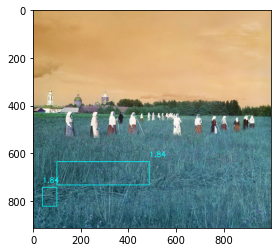

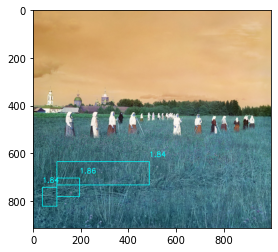

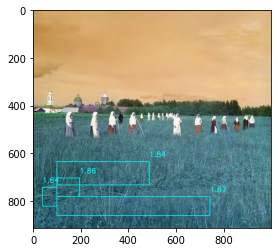

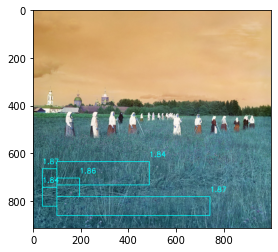

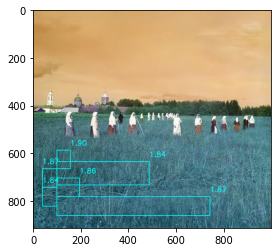

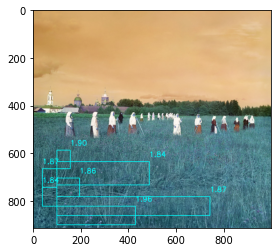

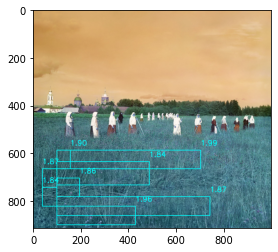

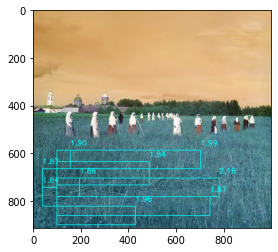

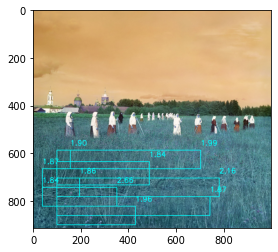

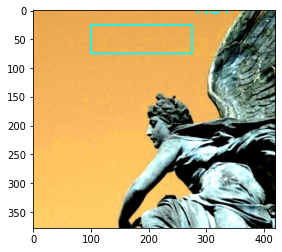

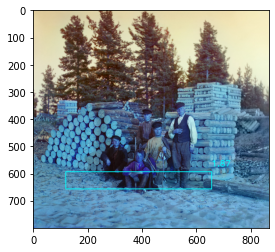

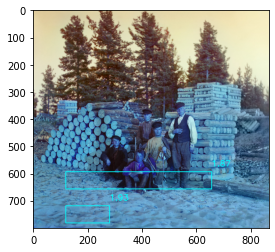

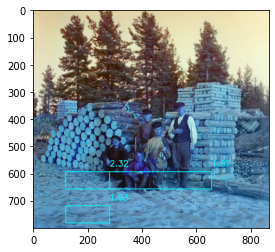

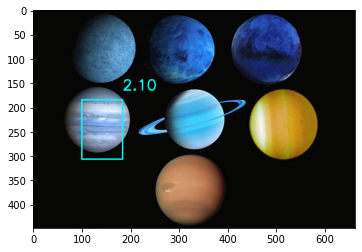

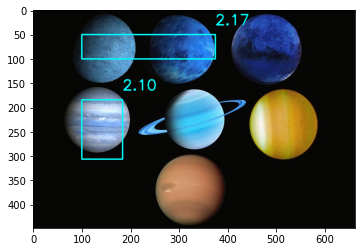

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from non_max_suppression import non_max_suppression_fast

BOW_NUM_TRAINING_SAMPLES_PER_CLASS = 10
SVM_NUM_TRAINING_SAMPLES_PER_CLASS = 100
SVM_SCORE_THRESHOLD = 1.8
NMS_OVERLAP_THRESHOLD = 0.15
sift = cv2.SIFT_create()
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = {}
flann = cv2.FlannBasedMatcher(index_params, search_params)
bow_kmeans_trainer = cv2.BOWKMeansTrainer(12)
bow_extractor = cv2.BOWImgDescriptorExtractor(sift, flann)

def get_pos_and_neg_paths(i):
    pos_path = f"data/CarData/TrainImages/pos-{i+1}.pgm"
    neg_path = f"data/CarData/TrainImages/neg-{i+1}.pgm"
    return pos_path, neg_path

def add_sample(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    if descriptors is not None:
        bow_kmeans_trainer.add(descriptors)

for i in range(BOW_NUM_TRAINING_SAMPLES_PER_CLASS):
    pos_path, neg_path = get_pos_and_neg_paths(i)
    add_sample(pos_path)
    add_sample(neg_path)
voc = bow_kmeans_trainer.cluster()
bow_extractor.setVocabulary(voc)

def extract_bow_descriptors(img):
    features = sift.detect(img)
    return bow_extractor.compute(img, features)

training_data = []
training_labels = []
for i in range(SVM_NUM_TRAINING_SAMPLES_PER_CLASS):
    pos_path, neg_path = get_pos_and_neg_paths(i)
    pos_img  = cv2.imread(pos_path, cv2.IMREAD_GRAYSCALE)
    pos_descriptors = extract_bow_descriptors(pos_img)
    if pos_descriptors is not None:
        training_data.extend(pos_descriptors)
        training_labels.append(1)
    neg_img  = cv2.imread(neg_path, cv2.IMREAD_GRAYSCALE)
    neg_descriptors = extract_bow_descriptors(neg_img)
    if neg_descriptors is not None:
        training_data.extend(neg_descriptors)
        training_labels.append(-1)
svm = cv2.ml.SVM_create()
# 不好使？
# svm.load("my_svm.xml")
svm.setType(cv2.ml.SVM_C_SVC)
svm.setC(50)
svm.train(np.array(training_data), cv2.ml.ROW_SAMPLE, np.array(training_labels))
svm.save("my_svm.xml")
def pyramid(img, scale_facotr=1.25, min_size=(200, 80), max_size=(600, 600)):
    h, w = img.shape
    min_w, min_h = min_size
    max_w, max_h = max_size
    while w >= min_w and h >= min_h:
        if w <= max_w and h <= max_h:
            yield img
        w /= scale_facotr
        h /= scale_facotr
        # interpolation 插值
        img = cv2.resize(img, (int(w), int(h)), interpolation=cv2.INTER_AREA)

def sliding_window(img, step=20, window_size=(100, 40)):
    img_h, img_w = img.shape
    window_w, window_h = window_size
    for y in range(0, img_w, step):
        for x in range(0, img_h, step):
            roi = img[y:y+window_h, x:x+window_w]
            roi_h, roi_w = roi.shape
            if roi_w == window_w and roi_h == window_h:
                yield (x, y, roi)

for test_img_path in ["data/CarData/TestImages/test-0.pgm", "data/CarData/TestImages/test-1.pgm", "images/car.jpg", \
"images/haying.jpg", "images/statue_small.jpg", "images/woodcutters.jpg", "images/planet_glow.jpg"]:
    img = cv2.imread(test_img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pos_rects = []
    for resized in pyramid(gray_img):
        for x, y, roi in sliding_window(resized):
            descriptors = extract_bow_descriptors(roi)
            if descriptors is None:
                continue
            prediction = svm.predict(descriptors)
            if prediction[1][0][0] == 1.0:
                raw_prediction = svm.predict(descriptors, flags=cv2.ml.STAT_MODEL_RAW_OUTPUT)
                score = - raw_prediction[1][0][0]
                if score > SVM_SCORE_THRESHOLD:
                    h, w = roi.shape
                    scale = gray_img.shape[0] / float(resized.shape[0])
                    pos_rects.append([int(x * scale), int(y * scale), int((x+w) * scale), int((y+h) * scale), score])
    pos_rects = non_max_suppression_fast(np.array(pos_rects), NMS_OVERLAP_THRESHOLD)
    for x0, y0, x1, y1, score in pos_rects:
        cv2.rectangle(img, (int(x0), int(y0)), (int(x), int(y1)), (0, 255, 255), 2 )
        cv2.putText(img, f"{score:.2f}", (int(x0), int(y0) - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        plt.imshow(img)
        plt.show()